## MISA Load and Query Model

This notebook loads the previously trained models for Ne, Te, and Ti, and defines some functions to use them.

#### Loading variables, defining functions

### 1a. Load

<xarray.DataArray 'ut' (dates: 1631520)> Size: 13MB
[1631520 values with dtype=float64]
Coordinates:
  * dates    (dates) datetime64[ns] 13MB 1932-01-01 ... 2025-01-21T23:30:00

In [1]:
# add root directory to path
import sys
sys.path.append("../")
from MISA_pySLIME import *

/Users/mateo/Documents/dev/Haystack/MISA_pySLIME/.venv/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mateo/Documents/dev/Haystack/MISA_pySLIME/.venv/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mateo/Documents/dev/Haystack/MISA_pySLIME/.venv/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning

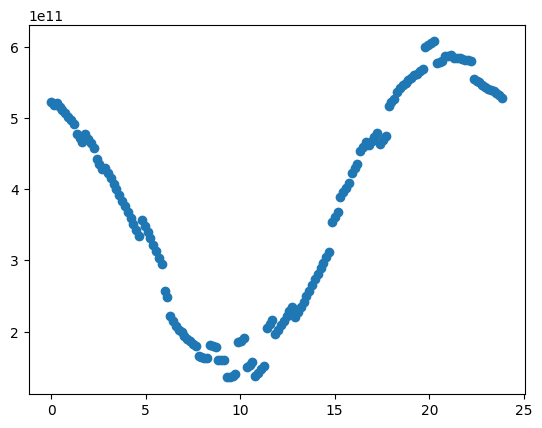

In [3]:
from matplotlib import pyplot as plt
import numpy as np
# evaluate predictions
predictions = [
    predict_ne(
        coords = (-80,350),
        doy=99,
        time=time,
        year=2024,
        input_coords='az_alt',
        time_ref='ut'
    )
    for time in np.arange(0,24,0.15)
]

plt.scatter(np.arange(0,24,0.15), predictions, label='Predictions')
# plt.ylim(0, 1e12)

### load/bin a test day, compare with residuals with model

In [5]:
from datetime import datetime
### load data
def timestamp_to_decimal_hour(timestamp):
    utc_time = datetime.utcfromtimestamp(timestamp)
    return utc_time.hour + utc_time.minute / 60 + utc_time.second / 3600

test_date = np.datetime64('2024-04-07') # define the test date
test_xr = xr.open_dataset('/Users/mateo/Documents/dev/Haystack/AzimuthalScans/content/EclipseReport/mlh240407k.004.nc') # make sure to use the correct data product


### recorded data product processing
# Construct UT from UTC timestamp and attach to test dataset
dates = []
times = test_xr['timestamps'].data
ut = np.zeros(len(times))
for i in range(len(times)):
    temp = datetime.utcfromtimestamp(times[i])
    dates.append(temp)
    ut[i] = temp.hour + temp.minute / 60.0 + temp.second / 3600.0
# Convert the list of datetime objects to a pandas DatetimeIndex
pd_dates = pd.to_datetime(dates)
# Add the dates as a new coordinate in the xarray Dataset and set it as a dimension
test_xr = test_xr.assign_coords(dates=('timestamps', pd_dates))
test_xr = test_xr.swap_dims({'timestamps': 'dates'})
# Add UT hour variable to the dataset
ut = [timestamp_to_decimal_hour(ts) for ts in test_xr.timestamps.data]
test_xr['ut'] = (('dates',), ut)
test_xr['ut'].attrs = {
    "units": "hour of the day in decimal format",
    "long_name": "Universal Time Hour",
    "description": "Time in UTC expressed as a decimal hour."
}
# Add te variable to the dataset
test_xr['te'] = test_xr['tr'] * test_xr['ti']
test_xr['dte'] = test_xr['dtr'] * test_xr['dti']
# Add SLT variable to the dataset
slt = (test_xr.glon/15) + test_xr.ut # calculate correct SLT
test_xr['slt'] = (slt)
test_xr['slt'].attrs = {
    "units": "hours",
    "long_name": "Solar Local Time",
    "description": "Time in hours of the day, adjusted for longitude."
}
test_xr['az_normalized'] = (test_xr['az1'] + test_xr['az2']) / 2 # normalize az

# reindex the xr according to recorded dates dim
master_geo_ds_reindexed = master_geo_ds.reindex(dates=test_xr['dates'], method='ffill') 
for var in master_geo_ds_reindexed.var(): # append indices to radar data
    test_xr[var] = master_geo_ds_reindexed[var]

### bin data by azimuth and generate modeled day with identical conditions
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

### target params
# target azimuth and width
target_az = -80
daz = 5
# Define bins for parameters
bins = {
    'alt': np.arange(101, 490, 25),  # Altitude bins (0-500 km, 50 km steps)
    'slt': np.arange(6, 19, .5) # time bins
}

# load and mask
target_xr = test_xr.copy(deep=True)
target_xr = target_xr.where(target_xr['dates'].dt.date == np.datetime64(test_date),drop=False) # target april 7th
az_mask = (target_xr['az1'] > (target_az - daz)) & (target_xr['az1'] < (target_az + daz))
target_xr = target_xr.where(az_mask, drop=True)
doy = pd.Timestamp(test_date).dayofyear


# ut_value = pd.Timestamp(target_xr.dates.data).hour + pd.Timestamp(target_xr.dates.data).minute / 60 + pd.Timestamp(target_xr.dates.data).second / 3600
# Adjust the shapes to match the number of bins (edges - 1)
n_alt_bins = len(bins['alt']) - 1
n_slt_bins = len(bins['slt']) - 1

Z = np.zeros((n_alt_bins, n_slt_bins))
Z_modeled = np.zeros((n_alt_bins, n_slt_bins))
lats = np.zeros((n_alt_bins, n_slt_bins))
lons = np.zeros((n_alt_bins, n_slt_bins))
r2s = np.zeros(len(bins['alt']))
for i,alt in enumerate(tqdm(bins['alt'][:-1])):
    alt_mask = (target_xr.gdalt >= bins['alt'][i]) & (target_xr.gdalt < bins['alt'][i+1])
    alt_masked_xr = target_xr.where(alt_mask, drop=False)
    # xr_alt = target_xr.where(alt_mask, drop=True)
    target_values_row = []
    modeled_values_row = []
    for j,slt in enumerate(bins['slt'][:-1]):
        slt_mask = (alt_masked_xr.slt >= bins['slt'][j]) & (alt_masked_xr.slt < bins['slt'][j+1])
        target_lats = alt_masked_xr.gdlat.where(slt_mask,drop=True).data.flatten()
        target_lons = alt_masked_xr.glon.where(slt_mask,drop=True).data.flatten()
        target_values = alt_masked_xr['ti'].where(slt_mask,drop=True).data.flatten()
        if len(target_values) == 0:
            Z[i,j] = np.nan
            continue
        # target_ap30s = alt_masked_xr.ap30.where(ut_mask,drop=True).data.flatten()
        # target_fism2s = alt_masked_xr.fism2.where(ut_mask,drop=True).data.flatten()
        # target_smes = alt_masked_xr.sme.where(ut_mask, drop=True).data.flatten()

        target_azs = np.repeat(target_az, len(target_lats))
        target_alts = np.repeat(alt, len(target_lats))
        target_slts = np.repeat(slt, len(target_lats))
        target_doys = np.repeat(doy, len(target_lats))

        # modeled_values = predict_ne_poly(target_azs,target_alts,target_uts,target_ap30s,target_fism2s,target_smes,bin_models)
        # modeled_values = predict_ti(target_azs,target_alts,target_doys,target_slts,year=2024)
        modeled_values = predict_ti(
        coords = list(zip(target_azs.tolist(),target_alts.tolist())),
        doy=target_doys,
        time=target_slts,
        year=2024,
        input_coords='az_alt',
        time_ref='slt'
    )

        # doys= np.repeat(doy,len(target_values))
        # slts = np.repeat(slt,len(target_values))
        # alts = np.repeat(alt,len(target_values))

        # append recorded data to master list
        Z[i,j] = np.nanmean(target_values)
        Z_modeled[i,j] = np.mean(modeled_values)

        lats[i,j] = np.nanmean(target_lats) # good approx
        lons[i,j] = np.nanmean(target_lons) # good approx
    # r2 = r2_score(modeled_values_row, target_values_row)
    # r2s[i] = r2

100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


/var/folders/46/7rtdvrg92h175wj3d6dq0zjr0000gn/T/ipykernel_52090/304448936.py:34: UserWarning: The following kwargs were not used by contour: 'extendfrac'
  cs = ax.contourf(


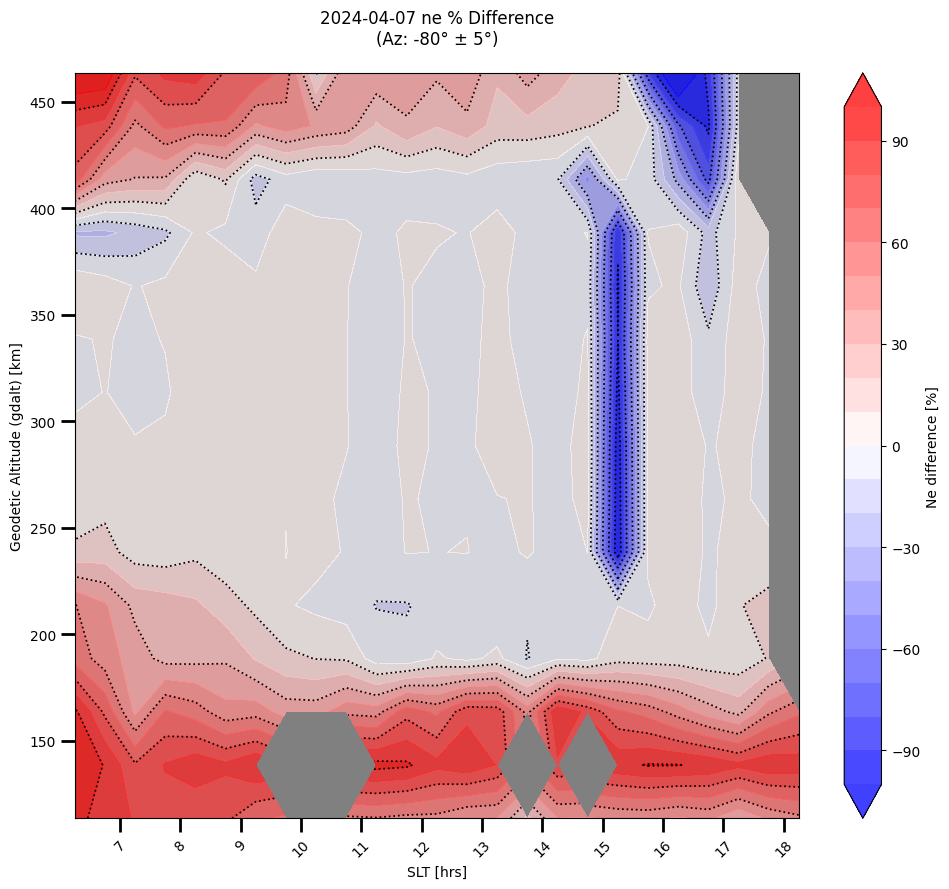

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Example levels for ±100% difference in 21 steps
levels = np.linspace(-100, 100, 21)

# Compute the midpoints of the bins.
alt_midpoints = (bins['alt'][:-1] + bins['alt'][1:]) / 2
slt_midpoints = (bins['slt'][:-1] + bins['slt'][1:]) / 2

# Create a meshgrid from the midpoints so the grid matches the shape of difference_percent.
X, Y = np.meshgrid(slt_midpoints, alt_midpoints)

# Compute the difference percent (ensure Z and Z_modeled are of shape (n_alt_bins, n_slt_bins))
difference_percent = (((Z - Z_modeled) / Z) * 100)

# Create a copy of the 'bwr' colormap and set the 'bad' (NaN) color to grey
cmap = plt.get_cmap('bwr').copy()
cmap.set_bad(color='grey')

fig, ax = plt.subplots(figsize=(10, 9))

# (1) Optional line contours (in black, dotted)
cs2 = ax.contour(
    X, Y, difference_percent,
    levels=levels[1::2],      # e.g. every other level for line contours
    colors='black',
    linewidths=1.25,
    linestyles='dotted'
)

# (2) Filled contours - set NaN areas to grey
cs = ax.contourf(
    X, Y, difference_percent,
    levels=levels,
    cmap=cmap,
    extend='both',  # so color extends beyond min/max
    extendfrac='auto',
    alpha=0.75
)

cbar = plt.colorbar(cs, ax=ax, label='Ne difference [%]')

# Set axis labels and facecolor
ax.set_xlabel('SLT [hrs]')
ax.set_ylabel('Geodetic Altitude (gdalt) [km]')
ax.set_facecolor('grey')

title = f'{test_date} ne % Difference\n(Az: {target_az}° ± {daz}°)'
ax.set_title(title + '\n')

# Format x-axis with custom time labels if needed
# ax.xaxis.set_major_formatter(plt.FuncFormatter(ut_to_hhmm))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=23))
ax.tick_params(length=10, width=2)
plt.xticks(rotation=45)

# Adjust plot limits based on the bin edges (or midpoints)
ax.set_xlim(slt_midpoints[0], slt_midpoints[-1])
ax.set_ylim(alt_midpoints[0], alt_midpoints[-1])

plt.tight_layout()
plt.show()

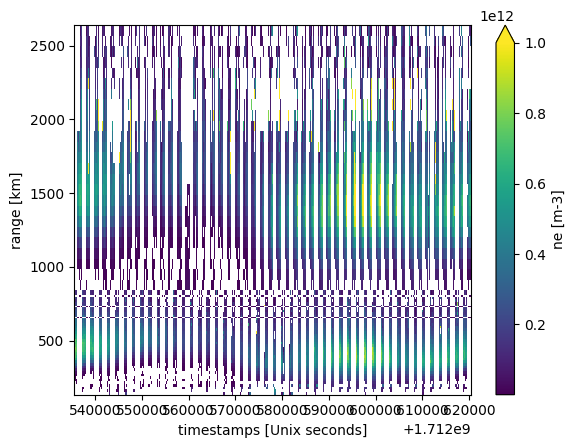

In [ ]:
test_xr = xr.open_dataset('/Users/mateo/Documents/dev/Haystack/AzimuthalScans/content/EclipseReport/mlh240408k.004.nc')
test_xr.ne.T.plot(vmax=1e12)